# CS598 CASS Notebook


### Connect to Google Drive

In [22]:
from google.colab import drive
import os

drive.mount('/content/drive') # link to drive hosting the datasets

# Jack, Robbie use this one
#datasets_path = '/content/drive/Shared with me/598-58/datasets'

# Or, if you are the owner (brianib2) and shared it with others:
# NOTE: Jack using link below now as well - Made shortcut from Shared file into My Drive for interoperability
datasets_path = '/content/drive/My Drive/598-58/datasets'

# test drive access ; list files in the specified folder
files = os.listdir(datasets_path)
print(files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['brain-tumor-dataset']


In [23]:
# install necessary libraries (from requirements.txt)
!pip install einops==0.4.1
!pip install matplotlib==3.5.2
!pip install matplotlib-inline==0.1.2
!pip install numpy==1.23.1
!pip install pandas==1.4.3
!pip install Pillow==9.2.0
!pip install scikit-learn==1.1.1
!pip install scipy==1.8.1
!pip install tensorboard==2.9.1
!pip install timm==0.5.4
!pip install torch==1.11.0+cu113
!pip install torchaudio==0.11.0+cu113
!pip install torchcontrib==0.0.2
!pip install torchmetrics==0.9.2
!pip install torchvision==0.12.0+cu113
!pip install vit-pytorch==0.35.8
!pip install pytorch-lightning==1.6.5
!pip install tqdm==4.64.0
!pip install medmnist

ERROR: Could not find a version that satisfies the requirement torch==1.11.0+cu113 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2)
ERROR: No matching distribution found for torch==1.11.0+cu113
ERROR: Could not find a version that satisfies the requirement torchaudio==0.11.0+cu113 (from versions: 0.11.0, 0.12.0, 0.12.1, 0.13.0, 0.13.1, 2.0.0, 2.0.1, 2.0.2, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2)
ERROR: No matching distribution found for torchaudio==0.11.0+cu113
ERROR: Could not find a version that satisfies the requirement torchvision==0.12.0+cu113 (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2)
ERROR: No matching distribution found for torchvision==0.12.0+cu113


## Datasets

In [24]:
# ISIC 2019 (no ground truth available)
# https://challenge.isic-archive.com/data/#2019
# Brain Tumor MRI database
# https://figshare.com/articles/dataset/brain_tumor_dataset/1512427



## CASS

In [25]:
# imports
import os
import numpy as np
import pytorch_lightning as pl
import torch
import pandas as pd
import timm
import math
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from torchvision import transforms as tsfm
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchcontrib.optim import SWA
from torchmetrics import Metric
from torch.utils.tensorboard import SummaryWriter

# Get Started with MNIST and CASS
* TODO that this code below differs in some areas from the CASS.ipynb file in the MedMNIST example folder. I think we may need to move to the CASS.ipynb implementation as this is what is used with the rest of the model code. - Jack 4/3

In [26]:
!pip install medmnist

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [27]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [28]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [29]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
train_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [30]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 10004
    Root location: /root/.medmnist
    Split: val
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K i

In [31]:
label_num2str={'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


In [32]:
label_str2num={}
for i in label_num2str:
    label_str2num[label_num2str[i]]=i

In [33]:
label_str2num


{'adipose': '0',
 'background': '1',
 'debris': '2',
 'lymphocytes': '3',
 'mucus': '4',
 'smooth muscle': '5',
 'normal colon mucosa': '6',
 'cancer-associated stroma': '7',
 'colorectal adenocarcinoma epithelium': '8'}

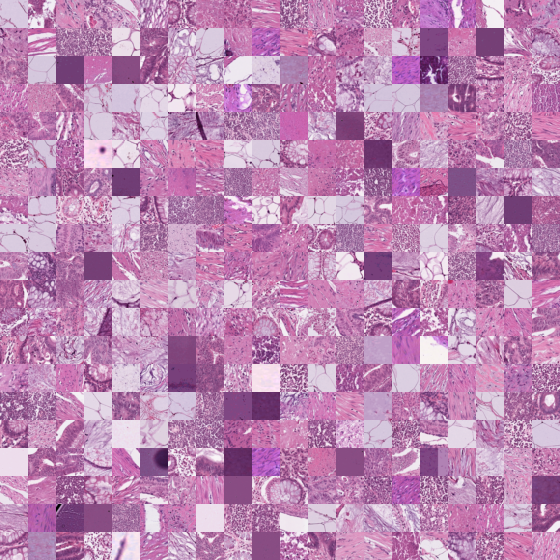

In [34]:
train_dataset.montage(length=20)


In [35]:
!pip install pytorch_lightning

import os
import numpy as np
import pytorch_lightning as pl
import torch
import pandas as pd
import timm
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import KFold
from torchvision import transforms as tsfm
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import seed_everything
from torchcontrib.optim import SWA
from torchmetrics import Metric

In [36]:
dist={}
for _,i in train_dataset:
    if i[0] in dist:
        dist[i[0]]+=1
    else:
        dist[i[0]]=1

dist

{5: 1354, 0: 1041, 1: 1057, 7: 1045, 4: 890, 3: 1156, 8: 1432, 6: 877, 2: 1152}

In [37]:
from collections import OrderedDict
dist = OrderedDict(sorted(dist.items()))
dist=dict(dist)

dist

{0: 1041, 1: 1057, 2: 1152, 3: 1156, 4: 890, 5: 1354, 6: 877, 7: 1045, 8: 1432}

In [38]:
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

# assign array and range
array_1d = dist.values()
range_to_normalize = (0.2, 1)
normalized_array_1d = normalize(
    array_1d, range_to_normalize[0],
  range_to_normalize[1])

# display original and normalized array
print("Original Array = ", array_1d)
print("Normalized Array = ", normalized_array_1d)

Original Array =  dict_values([1041, 1057, 1152, 1156, 890, 1354, 877, 1045, 1432])
Normalized Array =  [0.43639639639639644, 0.4594594594594595, 0.5963963963963964, 0.6021621621621622, 0.21873873873873875, 0.8875675675675676, 0.2, 0.4421621621621622, 1.0]


# CFG
* Used throughout code
* Appears to be different in general CASS.ipynb and the MedMNIST example.
* Below is from the MedMNIST example CASS.ipynb code.

In [39]:
class CFG:
    # We dont need to give the path to CSV and images as medMNIST provides dataloaders out of hte box.
    # Check MNIST Get-started-DEDL.ipynb for details on how to get the label to num, num to label and
    # class weights for the MedMNIST dataset.
    label_num2str = {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    label_str2num = {'adipose': '0',
 'background': '1',
 'debris': '2',
 'lymphocytes': '3',
 'mucus': '4',
 'smooth muscle': '5',
 'normal colon mucosa': '6',
 'cancer-associated stroma': '7',
 'colorectal adenocarcinoma epithelium': '8'}
    fl_alpha = 1.0  # alpha of focal_loss
    fl_gamma = 2.0  # gamma of focal_loss
    cls_weight =  [0.4368473694738948, 0.4597319463892779, 0.5959191838367675, 0.6024804960992198, 0.21920384076815363, 0.8874974994999001, 0.2, 0.4424484896979396, 1.0]
    cnn_name='resnet50'
    vit_name='vit_base_patch16_384'
    seed = 77
    num_classes = 4
    batch_size = 16
    t_max = 16
    lr = 1e-3
    min_lr = 1e-6
    n_fold = 6
    num_workers = 8
    gpu_idx = 0
    device = torch.device(f'cuda:{gpu_idx}' if torch.cuda.is_available() else 'cpu')
    gpu_list = [gpu_idx]

# Focal Loss
* Used later in the model
* Appears to be the same in general CASS.ipynb and the MedMNIST example.

In [40]:
"""
Define Focal-Loss
"""

class FocalLoss(nn.Module):
    """
    The focal loss for fighting against class-imbalance
    """
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = 1e-12  # prevent training from Nan-loss error
        self.cls_weights = torch.tensor([CFG.cls_weight],dtype=torch.float, requires_grad=False, device=CFG.device)

    def forward(self, logits, target):
        """
        logits & target should be tensors with shape [batch_size, num_classes]
        """
        probs = torch.sigmoid(logits)
        one_subtract_probs = 1.0 - probs
        # add epsilon
        probs_new = probs + self.epsilon
        one_subtract_probs_new = one_subtract_probs + self.epsilon
        # calculate focal loss
        log_pt = target * torch.log(probs_new) + (1.0 - target) * torch.log(one_subtract_probs_new)
        pt = torch.exp(log_pt)
        focal_loss = -1.0 * (self.alpha * (1 - pt) ** self.gamma) * log_pt
        focal_loss = focal_loss * self.cls_weights
        return torch.mean(focal_loss)

# F1 Score
* Appears to be the same in general CASS.ipynb and the MedMNIST example.
* Can modify to get recall as well (see comment below)

In [41]:
"""
Define F1 score metric
"""
class MyF1Score(Metric):
    def __init__(self, cfg, threshold: float = 0.5, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.cfg = cfg
        self.threshold = threshold
        self.add_state("tp", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("fp", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("fn", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        assert preds.shape == target.shape
        preds_str_batch = self.num_to_str(torch.sigmoid(preds))
        target_str_batch = self.num_to_str(target)
        tp, fp, fn = 0, 0, 0
        for pred_str_list, target_str_list in zip(preds_str_batch, target_str_batch):
            for pred_str in pred_str_list:
                if pred_str in target_str_list:
                    tp += 1
                if pred_str not in target_str_list:
                    fp += 1

            for target_str in target_str_list:
                if target_str not in pred_str_list:
                    fn += 1
        self.tp += tp
        self.fp += fp
        self.fn += fn

    def compute(self):
        #To switch between F1 score and recall.
        f1 = 2.0 * self.tp / (2.0 * self.tp + self.fn + self.fp)
        #rec = self.tp/(self.tp + self.fn)
        return f1

    def num_to_str(self, ts: torch.Tensor) -> list:
        batch_bool_list = (ts > self.threshold).detach().cpu().numpy().tolist()
        batch_str_list = []
        for one_sample_bool in batch_bool_list:
            lb_str_list = [self.cfg.label_num2str[lb_idx] for lb_idx, bool_val in enumerate(one_sample_bool) if bool_val]
            batch_str_list.append(lb_str_list)
        return batch_str_list

# Self-Supervised Learning (SSL) Train Function
* From MedMNIST example code
* Almost identical to general CASS.ipynb (see one comment below for difference).
* Also included loss function which is same in both CASS files

In [42]:
def ssl_train_model(train_loader,model_vit,criterion_vit,optimizer_vit,scheduler_vit,model_cnn,criterion_cnn,optimizer_cnn,scheduler_cnn,num_epochs):
    writer = SummaryWriter()
    phase = 'train'
    model_cnn.train()
    model_vit.train()
    f1_score_cnn=0
    f1_score_vit=0
    for i in tqdm(range(num_epochs)):
        with torch.set_grad_enabled(phase == 'train'):
            # Note non MedMNIST example code does not use tqdm() below
            for img,_ in tqdm(train_loader):
                f1_score_cnn=0
                f1_score_vit=0
                # TODO Need to define device for this below
                img = img.to(device)
                pred_vit = model_vit(img)
                pred_cnn = model_cnn(img)
                model_sim_loss=loss_fn(pred_vit,pred_cnn)
                loss = model_sim_loss.mean()
                loss.backward()
                optimizer_cnn.step()
                optimizer_vit.step()
                scheduler_cnn.step()
                scheduler_vit.step()
            print('For -',i,'Loss:',loss)
            writer.add_scalar("Self-Supervised Loss/train", loss, i)
    writer.flush()

def loss_fn(x, y):
    x =  torch.nn.functional.normalize(x, dim=-1, p=2)
    y =  torch.nn.functional.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)